In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
from scipy import stats
from scipy.special import expit
from nested_pandas import read_parquet
from joblib import Parallel, delayed

from tdastro.obstable.roman_obstable import RomanObsTable
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
    num_snia_per_redshift_bin,
)
from tdastro.math_nodes.scipy_random import SamplePDF
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.simulate import simulate_lightcurves
from tdastro.models.sncomso_models import SncosmoWrapperModel
from tdastro.models.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves
from tdastro.math_nodes.ra_dec_sampler import ObsTableUniformRADECSampler,ApproximateMOCSampler
from tdastro.astro_utils.dustmap import DustmapWrapper,SFDMap
from tdastro.effects.extinction import ExtinctionEffect
from tdastro.astro_utils.mag_flux import mag2flux,flux2mag

from tdastro import _TDASTRO_BASE_DATA_DIR

from tdastro.validation.lcfit import fit_single_lc

In [3]:
%%time
# Load the OpSim data.

apt_table = pd.read_csv("roman_opsim/unknown.sim.ecsv",sep=r"\s+",comment="#")
apt_table = apt_table.loc[apt_table.BANDPASS != "PRISM"]

opsim_db = RomanObsTable(apt_table)

t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

passband_group = PassbandGroup.from_preset(preset="Roman")
print(f"Loaded Passbands: {passband_group}")

2025-09-09 16:58:11,160 - INFO - Loading passbands from preset Roman
2025-09-09 16:58:11,161 - INFO - Data file /Users/mi/Work/tdastro/tdastro/data/passbands/Roman/roman_wfi_filters.ecsv already exists. Skipping download.


Loaded OpSim with 47931 rows and times [61304.0, 62879.0]
Loaded Passbands: PassbandGroup containing 8 passbands: Roman_F062, Roman_F087, Roman_F106, Roman_F129, Roman_F146, Roman_F158, Roman_F184, Roman_F213
CPU times: user 196 ms, sys: 17.8 ms, total: 213 ms
Wall time: 565 ms


/Users/mi/Work/tdastro/tdastro/src/tdastro/astro_utils/passbands.py:360: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  table = pd.read_csv(table_path, comment="#", sep=r"[\s,]+")


In [4]:
# radec_node = ObsTableUniformRADECSampler(opsim_db, radius=np.sqrt(0.28/np.pi),
#                                          node_label="radec")
moc = opsim_db.build_moc(radius=np.sqrt(0.28/np.pi), max_depth=10)
radec_node = ApproximateMOCSampler(moc, depth=12)

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each hos instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.

zmin = 0.1
zmax = 1.2
H0 = 70.0
Omega_m = 0.3
nsn, z = num_snia_per_redshift_bin(zmin, zmax, 100, H0=H0, Omega_m=Omega_m)
zpdf = interp1d(z, nsn, bounds_error=False, fill_value=0)

host = SNIaHost(
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=10.,
    redshift=SamplePDF(zpdf),
    node_label="host",
)

In [5]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
m_abs_func = NumpyRandomFunc("normal", loc=-19., scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=NumpyRandomFunc("normal",loc=0, scale=0.2), 
    c=NumpyRandomFunc("normal",loc=0, scale=0.02),
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x0_func.x1,
    c=x0_func.c,
    ra=host.ra,#NumpyRandomFunc("normal", loc=host.ra, scale=0.001),
    dec=host.dec,#NumpyRandomFunc("normal", loc=host.dec, scale=0.001),
    redshift=host.redshift,
    node_label="source",
)
    
mwextinction = SFDMap(
    ra=source.ra,
    dec=source.dec,
    node_label="mwext",
)

# Create an extinction effect using the EBVs from that dust map.
ext_effect = ExtinctionEffect(extinction_model="F99", ebv=mwextinction, Rv=3.1)
source.add_effect(ext_effect)


2025-09-09 16:58:12,815 - INFO - SFD dust map data files not found.
Attempting to download from: ('https://github.com/kbarbary/sfddata/archive/master.tar.gz',)
to the directory /Users/mi/Work/tdastro/tdastro/data/dustmaps/sfdmap2


In [6]:
%%time
nsntotal = 500
print(nsntotal)
lightcurves = simulate_lightcurves(source, int(nsntotal), opsim_db, passband_group)
lightcurves

500


/Users/mi/Work/tdastro/tdastro/src/tdastro/obstable/roman_obstable.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations["sky"] = self.calculate_skynoise(observations["exptime"],1.5,observations["zodi_countrate_min"],observations["thermal_countrate"])
/Users/mi/Work/tdastro/tdastro/src/tdastro/obstable/roman_obstable.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations["sky"] = self.calculate_skynoise(observations["exptime"],1.5,observations["zodi_countrate_min"],observations["the

CPU times: user 3.59 s, sys: 807 ms, total: 4.39 s
Wall time: 4.7 s


id          ra        dec  nobs         z  \
0      0   60.829384 -49.069241   174  0.404960   
1      1  244.853126  54.942914   466  0.603387   
..   ...         ...        ...   ...       ...   
498  498  243.473094  53.200415   624  0.371791   
499  499  244.638447  54.361721     0  1.193737   

                                                params  \
0    {'ApproximateMOCSampler:uniform_2.ra': 60.8293...   
1    {'ApproximateMOCSampler:uniform_2.ra': 244.853...   
..                                                 ...   
498  {'ApproximateMOCSampler:uniform_2.ra': 243.473...   
499  {'ApproximateMOCSampler:uniform_2.ra': 244.638...   

                                            lightcurve  
0    [{mjd: 61344.0, filter: 'F184', flux: 12.58373...  
1    [{mjd: 61304.0, filter: 'F062', flux: 10.45315...  
..                                                 ...  
498  [{mjd: 61304.0, filter: 'F062', flux: -0.88039...  
499                                               None  

[500 rows x 7 columns]

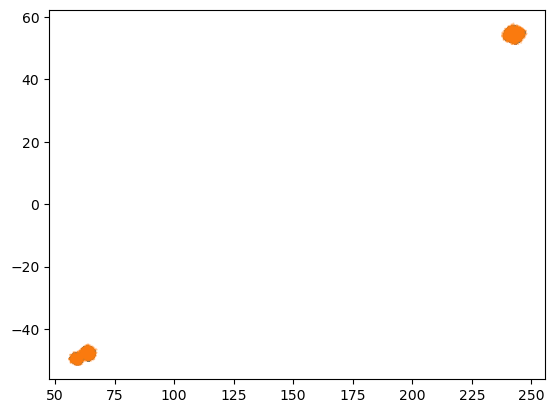

In [7]:
plt.plot(opsim_db._table.ra,opsim_db._table.dec,'.',alpha=0.02)
plt.plot(lightcurves.ra,lightcurves.dec,"*",alpha=0.2)

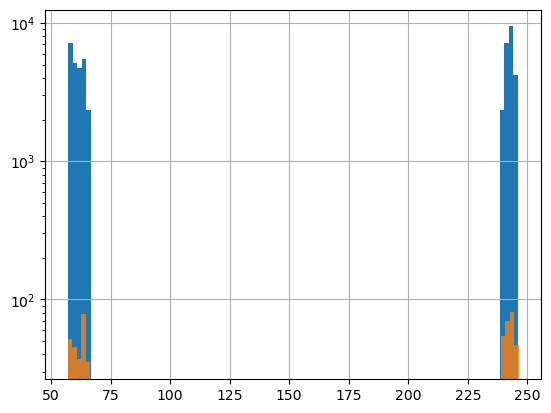

In [8]:
opsim_db._table.ra.hist(bins=100,density=False)
lightcurves.ra.hist(bins=100,alpha=0.8,density=False)
plt.yscale('log')

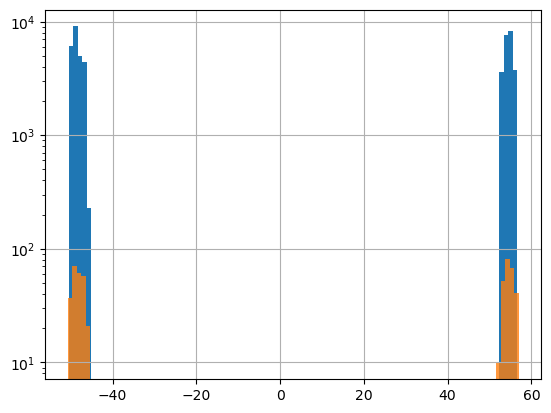

In [9]:
opsim_db._table.dec.hist(bins=100,density=False)
lightcurves.dec.hist(bins=100,alpha=0.8,density=False)
plt.yscale('log')

In [10]:
lightcurves['params'][0].keys()

dict_keys(['ApproximateMOCSampler:uniform_2.ra', 'ApproximateMOCSampler:uniform_2.dec', 'host.ra', 'host.dec', 'host.redshift', 'host.t0', 'host.distance', 'host.hostmass', 'SamplePDF:_rvs_3.function_node_result', 'source.ra', 'source.dec', 'source.redshift', 'source.t0', 'source.distance', 'source.x0', 'source.x1', 'source.c', 'source.Rv', 'source.ebv', 'NumpyRandomFunc:uniform_4.low', 'NumpyRandomFunc:uniform_4.high', 'NumpyRandomFunc:uniform_4.function_node_result', 'DistModFromRedshift:_distmod_from_redshift_6.redshift', 'DistModFromRedshift:_distmod_from_redshift_6.function_node_result', 'x0_func.distmod', 'x0_func.x1', 'x0_func.c', 'x0_func.alpha', 'x0_func.beta', 'x0_func.m_abs', 'x0_func.function_node_result', 'NumpyRandomFunc:normal_7.loc', 'NumpyRandomFunc:normal_7.scale', 'NumpyRandomFunc:normal_7.function_node_result', 'NumpyRandomFunc:normal_8.loc', 'NumpyRandomFunc:normal_8.scale', 'NumpyRandomFunc:normal_8.function_node_result', 'NumpyRandomFunc:normal_9.loc', 'NumpyRand

In [11]:
lightcurves.lightcurve.isna().sum()

np.int64(78)

In [12]:
#apply detection and spec efficiency
lightcurves = lightcurves.dropna(subset=['lightcurve'])
print("Before applying detection: nsn=", len(lightcurves))
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
lightcurves_after_detection = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
print("After applying detection: nsn=", len(lightcurves_after_detection))

Before applying detection: nsn= 422
After applying detection: nsn= 229


/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().__setitem__(nested, new_nested_series)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_69898/632368110.py:24: RuntimeWarning: invalid value encountered in log10
  lc_mag = -2.5*np.log10(lc_flux) + 31.4


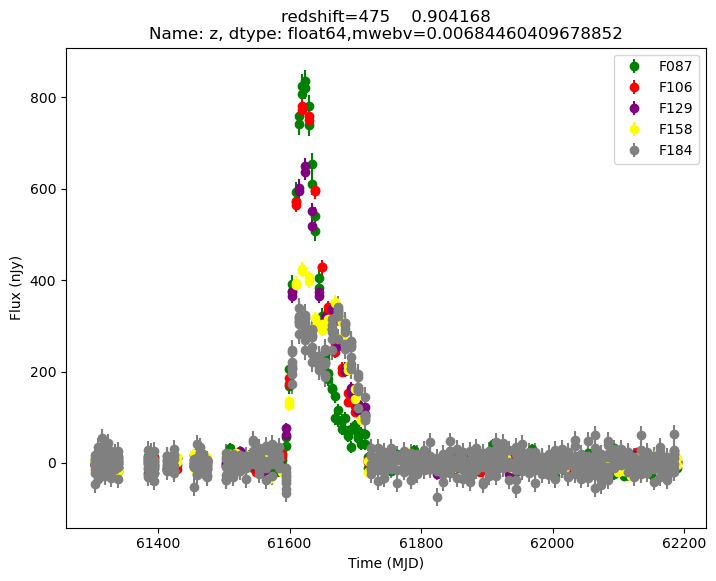

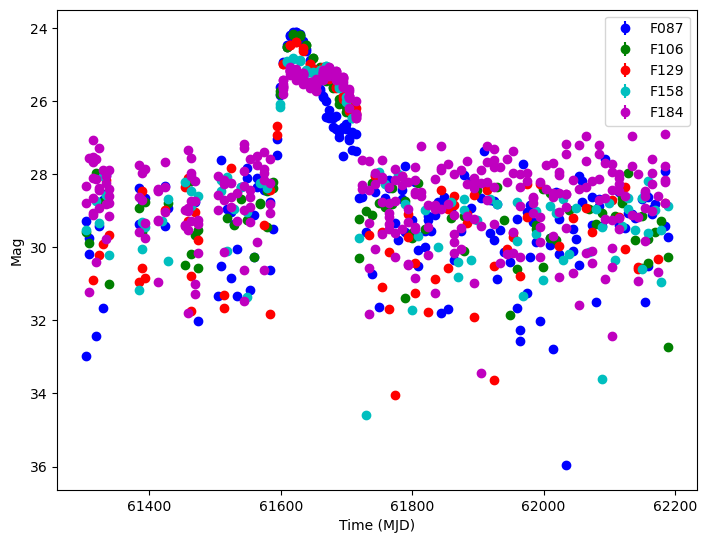

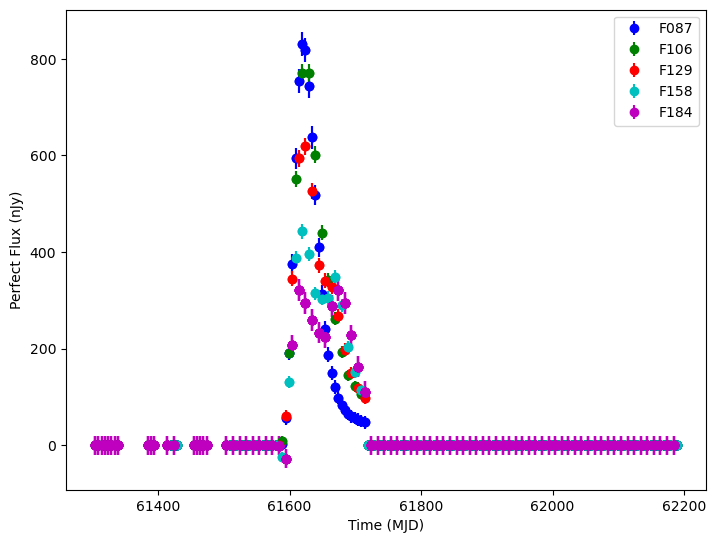

In [13]:
random_ids = lightcurves_after_detection.id.sample(1).values

colormap = {"F062":"blue",
            "F087":"green", 
            "F106":"red",
            "F129":"purple", 
            "F146":"cyan", 
            "F158":"yellow", 
            "F184":"gray", 
            "F213":"magenta",}

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[lightcurves.id==random_id]
    # lc = lightcurves_after_detection.loc[lightcurves_after_detection.id==random_id]
    
    if lc["nobs"].values[0] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve.filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve.mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve.flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve.fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)

        lc_fluxperfect = np.asarray(lc["lightcurve.flux_perfect"])
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            colormap=colormap,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['z']},mwebv={lc['params'].values[0]['mwext.ebv']}")
        plt.show()

        plot_lightcurves(
            fluxes=lc_mag,
            times=lc_mjd,
            fluxerrs=lc_magerr*1.e-4,
            filters=lc_filters,
        )
        plt.ylabel('Mag')
        plt.ylim(plt.ylim()[::-1])
        plt.show()

        plot_lightcurves(
            fluxes=lc_fluxperfect,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
        )
        plt.ylabel('Perfect Flux (nJy)')